In [1]:
import os
from typing import final
from pathlib import Path
from PIL import Image
import pandas as pd

import torchvision
from torchvision import transforms

import timm
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split

device = "cuda" if torch.cuda.is_available() else "cpu"

device

'cuda'

# Создаем датасеты

In [2]:
@final
class CustomDataset(Dataset):
    def __init__(self, class_to_label_csv: Path, images_dir: Path, has_labels=True, transform=None):
        self.class_to_label = pd.read_csv(class_to_label_csv)
        self.images_dir = images_dir
        self.images = [file_name for file_name in os.listdir(images_dir)]
        self.transform = transform if transform else transforms.ToTensor()
        self.has_labels = has_labels

        self.classes = sorted(self.class_to_label.iloc[:, 0].unique())
        self.class_to_idx = {row["name"]: row["label"] for idx, row in self.class_to_label.iterrows()}

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        file_name = self.images[idx]
        img_path = os.path.join(self.images_dir, file_name)
        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)

        if self.has_labels:
            cls = file_name.split("_")[0]
            label = self.class_to_idx[cls]
            return image, label
        else:
            return image, file_name

In [3]:
BATCH_SIZE = 32

full_train = CustomDataset(
    class_to_label_csv=Path("./animal/class_names.csv"), 
    images_dir=Path("./animal/train/"), 
    has_labels=True
)

train_size = int(0.8 * len(full_train))
val_size = len(full_train) - train_size

train_dataset, val_dataset = random_split(full_train, [train_size, val_size])

train_dataloader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, BATCH_SIZE, shuffle=False)

test = CustomDataset(
    class_to_label_csv=Path("./animal/class_names.csv"), 
    images_dir=Path("./animal/test_new/"), 
    has_labels=False
)

test_dataloader = DataLoader(test, BATCH_SIZE, shuffle=False)

# Грузим предобученную модель

In [4]:
model = timm.create_model(
    "convnext_large.fb_in22k_ft_in1k",
    pretrained=True,
    num_classes=14
)

In [5]:
from torchinfo import summary

summary(model)

Layer (type:depth-idx)                             Param #
ConvNeXt                                           --
├─Sequential: 1-1                                  --
│    └─Conv2d: 2-1                                 9,408
│    └─LayerNorm2d: 2-2                            384
├─Sequential: 1-2                                  --
│    └─ConvNeXtStage: 2-3                          --
│    │    └─Identity: 3-1                          --
│    │    └─Sequential: 3-2                        918,144
│    └─ConvNeXtStage: 2-4                          --
│    │    └─Sequential: 3-3                        295,680
│    │    └─Sequential: 3-4                        3,605,760
│    └─ConvNeXtStage: 2-5                          --
│    │    └─Sequential: 3-5                        1,181,184
│    │    └─Sequential: 3-6                        128,604,672
│    └─ConvNeXtStage: 2-6                          --
│    │    └─Sequential: 3-7                        4,721,664
│    │    └─Sequential: 3-8      

In [47]:
model.head.fc

Linear(in_features=1536, out_features=14, bias=True)

# Треним

In [48]:
for param in model.parameters():
    param.requires_grad = False

for param in model.head.fc.parameters():
    param.requires_grad = True

In [49]:
loss_fn = torch.nn.CrossEntropyLoss()

optim = torch.optim.Adam(params=model.parameters(), lr=1e-3)

epochs = 20

In [50]:
from misc import train_model

res = train_model(
    model, 
    train_dataloader,
    val_dataloader,
    loss_fn,
    optim,
    device,
    epochs
)

epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Train batches:   0%|          | 0/32 [00:00<?, ?it/s]

Test batches:   0%|          | 0/8 [00:00<?, ?it/s]

Train batches:   0%|          | 0/32 [00:00<?, ?it/s]

Test batches:   0%|          | 0/8 [00:00<?, ?it/s]

Train batches:   0%|          | 0/32 [00:00<?, ?it/s]

Test batches:   0%|          | 0/8 [00:00<?, ?it/s]

Train batches:   0%|          | 0/32 [00:00<?, ?it/s]

Test batches:   0%|          | 0/8 [00:00<?, ?it/s]

Train batches:   0%|          | 0/32 [00:00<?, ?it/s]

Test batches:   0%|          | 0/8 [00:00<?, ?it/s]

Train batches:   0%|          | 0/32 [00:00<?, ?it/s]

Test batches:   0%|          | 0/8 [00:00<?, ?it/s]

Train batches:   0%|          | 0/32 [00:00<?, ?it/s]

Test batches:   0%|          | 0/8 [00:00<?, ?it/s]

Train batches:   0%|          | 0/32 [00:00<?, ?it/s]

Test batches:   0%|          | 0/8 [00:00<?, ?it/s]

Train batches:   0%|          | 0/32 [00:00<?, ?it/s]

Test batches:   0%|          | 0/8 [00:00<?, ?it/s]

Train batches:   0%|          | 0/32 [00:00<?, ?it/s]

Test batches:   0%|          | 0/8 [00:00<?, ?it/s]

Train batches:   0%|          | 0/32 [00:00<?, ?it/s]

Test batches:   0%|          | 0/8 [00:00<?, ?it/s]

Train batches:   0%|          | 0/32 [00:00<?, ?it/s]

Test batches:   0%|          | 0/8 [00:00<?, ?it/s]

Train batches:   0%|          | 0/32 [00:00<?, ?it/s]

Test batches:   0%|          | 0/8 [00:00<?, ?it/s]

Train batches:   0%|          | 0/32 [00:00<?, ?it/s]

Test batches:   0%|          | 0/8 [00:00<?, ?it/s]

Train batches:   0%|          | 0/32 [00:00<?, ?it/s]

Test batches:   0%|          | 0/8 [00:00<?, ?it/s]

Train batches:   0%|          | 0/32 [00:00<?, ?it/s]

Test batches:   0%|          | 0/8 [00:00<?, ?it/s]

Train batches:   0%|          | 0/32 [00:00<?, ?it/s]

Test batches:   0%|          | 0/8 [00:00<?, ?it/s]

Train batches:   0%|          | 0/32 [00:00<?, ?it/s]

Test batches:   0%|          | 0/8 [00:00<?, ?it/s]

Train batches:   0%|          | 0/32 [00:00<?, ?it/s]

Test batches:   0%|          | 0/8 [00:00<?, ?it/s]

Train batches:   0%|          | 0/32 [00:00<?, ?it/s]

Test batches:   0%|          | 0/8 [00:00<?, ?it/s]

### Плотим результаты

In [52]:
from matplotlib import pyplot as plt

def plot_results(res):
    plt.figure(figsize=(12,12))
    i = 1
    for name in ("test", "train"):
        for metric in ("acc", "loss"):
            plt.subplot(2, 2, i)
            plt.xlabel("epoch")
            plt.ylabel(f"{name} {metric}")
            plt.plot(res[name][metric])
            i += 1

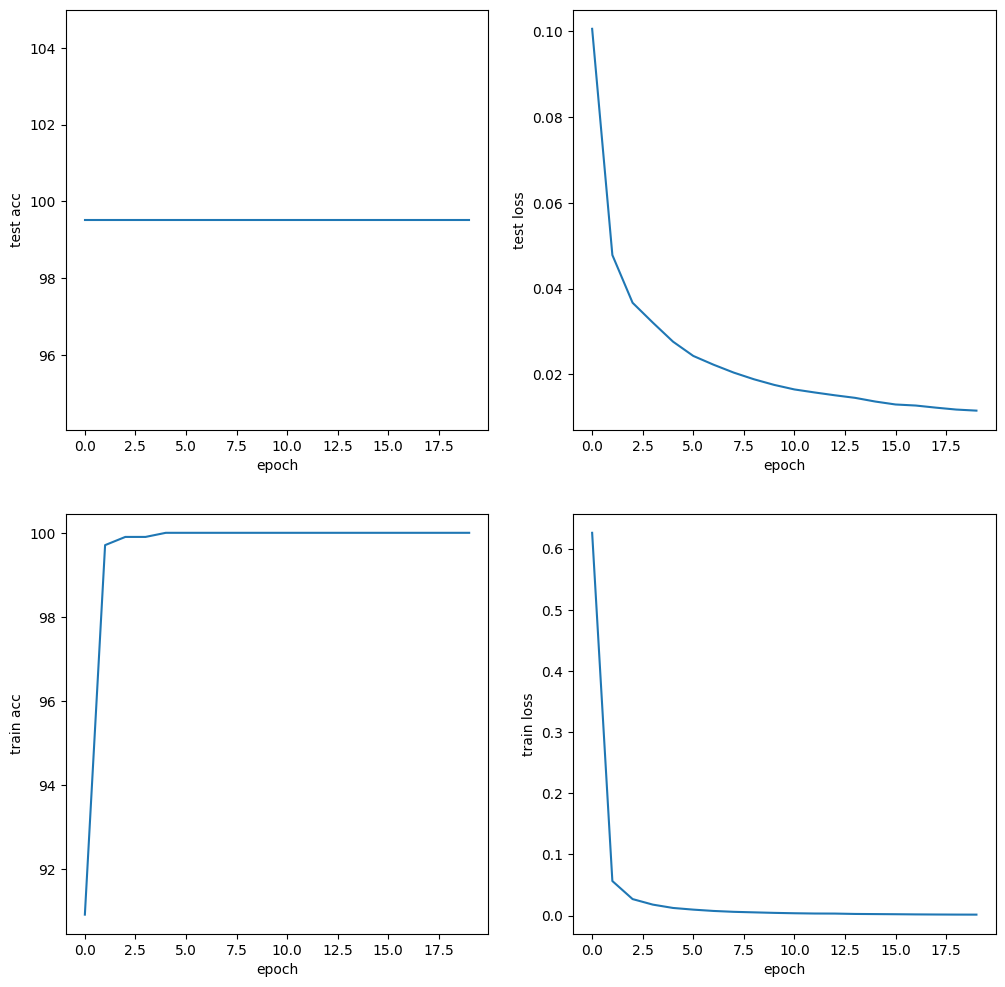

In [53]:
plot_results(res)

### Fine Tuning
Для более слабой модели сильно помогло (80 -> 90), но эта и так хорошо справляется

In [54]:
for param in model.parameters():
    param.requires_grad = True

optim = torch.optim.Adam(params=model.parameters(), lr=1e-5)

epochs = 5

In [ ]:
res = train_model(
    model, 
    train_dataloader,
    val_dataloader,
    loss_fn,
    optim,
    device,
    epochs
)

In [38]:
res["test"]["acc"][-1]

89.78365384615384

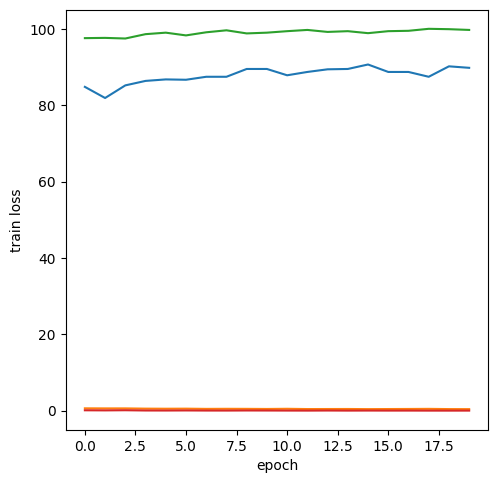

In [39]:
plot_results(res)

### Сохраняем

In [57]:
torch.save(model.state_dict(), "model.pt")

# Предиктим

In [4]:
model = timm.create_model(
    "convnext_large.fb_in22k_ft_in1k",
    pretrained=False,
    num_classes=14
).to(device)

model.load_state_dict(torch.load("model.pt"))

<All keys matched successfully>

In [6]:
from misc import predict

predictions = predict(model, test_dataloader, device)

Predicting:   0%|          | 0/14 [00:00<?, ?it/s]

In [11]:
len(predictions)

417

In [7]:
df = pd.DataFrame(predictions, columns=["FILE_NAME", "TARGET"])

In [14]:
df["num"] = df["FILE_NAME"].str.extract(r"(\d+)").astype(int)
df = df.sort_values(by="num").drop(columns="num")

In [15]:
df.head()

,FILE_NAME,TARGET
281,0.jpeg,0
327,1.jpeg,1
101,2.jpeg,4
250,3.jpeg,8
199,4.jpeg,13


In [16]:
df.to_csv("Mishin_Timofey_submission.csv", index=False)